Механизмы очистки памяти

Как мы уже знаем, язык Python является языком с автоматически управляемой памятью, то есть программисту, пишущему код на Python, не нужно беспокоиться о работе с памятью, в частности заниматься ее освобождением. Как только данные программы (объекты в Python) больше не нужны, Python автоматически освобождает память, которую они занимали. Несмотря на это, понимание того, как работает механизм очистки памяти, может помочь писать более качественный и производительный код.

Стандартный интерпретатор Python использует сразу два механизма очистки памяти:

подсчет ссылок
сборщик мусора (Garbage Collector, GC)

Подсчет ссылок

Алгоритм подсчета ссылок — это один из самых простых механизмов очистки памяти. Объекты удаляются как только на них больше нет ссылок.

Каждый объект в Python унаследован от базового класса PyObject, который содержит специальное поле Reference Count (ob_refcnt), в котором хранится количество ссылок на данный объект. Как только кто-то начинает ссылаться на объект, значение этого поля увеличивается на единицу. Если по какой-то причине ссылка пропадает, то это поле уменьшается на один. При этом если счетчик ссылок для определенного объекта достигает нуля, то интерпретатор запускает процесс уничтожения объекта. Если удаленный объект содержал ссылки на другие объекты, то эти ссылки также удаляются. Таким образом, удаление одного объекта может повлечь за собой удаление других.

Механизм подсчета ссылок работает в режиме реального времени.

In [ ]:
nums = [1, 2, 3]

создает объект, у которого поле Reference Count (ob_refcnt) равно 1.

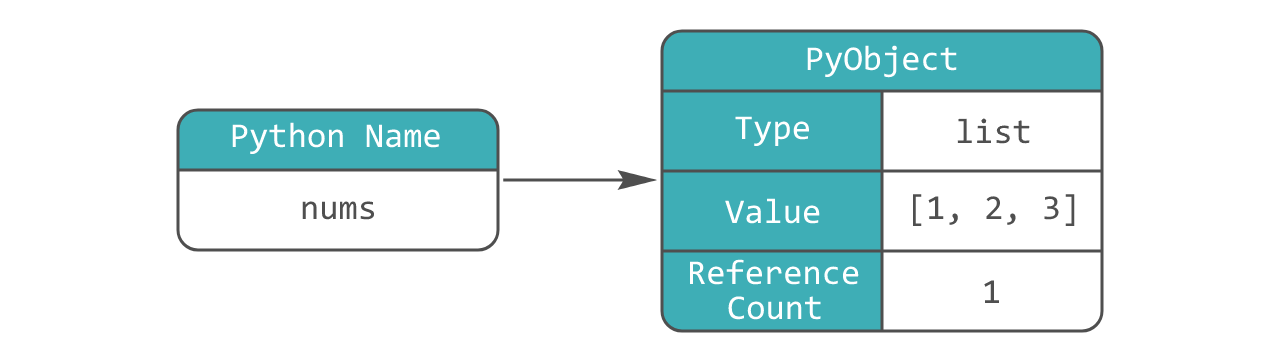

In [1]:
from functions import picture
picture('память8 (1).png')